# SNAX package tutorial

In [1]:
from snewpy.neutrino import Flavor
import os
from tqdm.notebook import tqdm
import numpy as np
from multimessenger.supernova import Supernova_Models as sn
from multimessenger.supernova.Plotter import Plotter
# import plotly.express as px
import astropy.units as u
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

The `SNAX` is a wrapper around `snewpy` and it allows to compute CEvNS rates for all the snewpy models.

In [2]:
# sn.models_list

Each model contains variuous simulations with e.g. different EoS, or different progenitor properties. <br>
When only `model_name` is passed to `sn.Models()` it displays the existing files and asks you to select one. Otherwise, `filename` or `index` can be passed. <br>
Once the model is executed, and after every heavy computation the data is saved, and the next time it is directly fetched from the stored data. <br>
The output folder can be specified with the `storage` argument.

In [3]:
# A.delete_object()

In [4]:
A = sn.Models(model_name='Fornax_2021', index=5)

> You chose ~wisely~ ->	   [5]	lum_spec_15M_r10000_dat.h5
> Retrieving object self.storage/Fornax_2021-lum_spec_15M_r10000_dat_h5.pickle
> Checking to see if you have strax already!


*** Detector definition message ***
You are currently using the default XENON10 template detector.



In [5]:
A

**Fornax_2021 Model**

|Parameter|Value|
|:--------|:----:|
|Progenitor mass | $15$ $\mathrm{M_{\odot}}$|
|composite | Xenon|
|distance | 10.0 kpc|
|duration | 4.1 s|
|executed | True|

In [6]:
A.compute_rates();

Computing for all isotopes:   0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

> Rates are computed at the source for 1 atom see rateper_Er/t attr (use scale_rates() for distance & volume)


### Plotter

One can also get a plotter, which takes the model object as input and allows for easy plotting. 

In [7]:
plotter = Plotter(A)

In [8]:
# plotter.plot_cross_section_fantastic()
# plotter.plot_cross_section();

In [9]:
# plotter.plot_form_factor()

In [10]:
# plotter.plot_recoil_spectrum()

In [11]:
# # not all models have same attributes
# # plotter.plot_mean_cross_section(); # --> doesn't work as there are no meanE attribute in Fornax
# B = sn.Models(model_name='Nakazato_2013', index=10)
# plotter_B = Plotter(B)
# plotter_B.plot_mean_cross_section();
# plotter_B.plot_params()

In [12]:
# plotter.plot_sampled_data(50000, dtype="time", xscale="log");

In [13]:
# plotter.plot_sampled_data(50000, xscale='lin');

# Scale

The rates are computed at the source and for  single atom for convenience. The rates are returned as object attributes e.g.
```python
A.rateper_t
A.rateper_Er
A.rateper_t_iso
A.rateper_Er_iso
```
where the corresponding recoil energies and the times are also stored as attributes with units
```python
A.recoil_energies
A.time
```
Thus, the user can scale the rates for any number of Xenon atoms (or another atom), and for any distance (10kpc etc.). The volume is not scaled by default i.e. returned values are counts/distance/1 ton however, it is straightforward linear multiplication to scale for 7 or 40 tonnes.<br>
see `A.scale_rates()`.

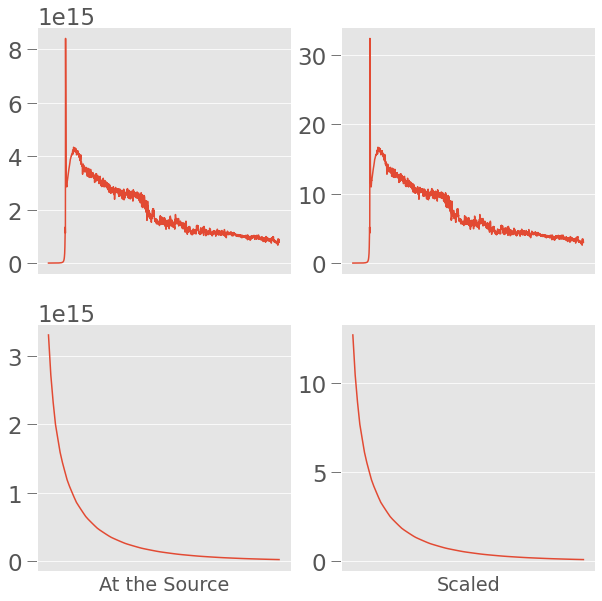

In [14]:
rates_scaled_Er, rates_scaled_t = A.scale_rates()

fig, ((ax1,ax2),((ax11,ax22))) = plt.subplots(ncols=2, nrows=2, figsize=(10,10))
ax1.plot(A.time, A.rateper_t['Total'])
ax2.plot(A.time, rates_scaled_t['Total'])
ax11.plot(A.recoil_energies, A.rateper_Er['Total'])
ax22.plot(A.recoil_energies, rates_scaled_Er['Total'])
ax11.set_xlabel("At the Source")
ax22.set_xlabel("Scaled")
for ax in [ax1,ax2,ax11,ax22]:
    ax.set_xticks([])

The plotter has a tool to compute the total expected counts for given distances and given volumes. This already provides a nice way of benchmarking models.

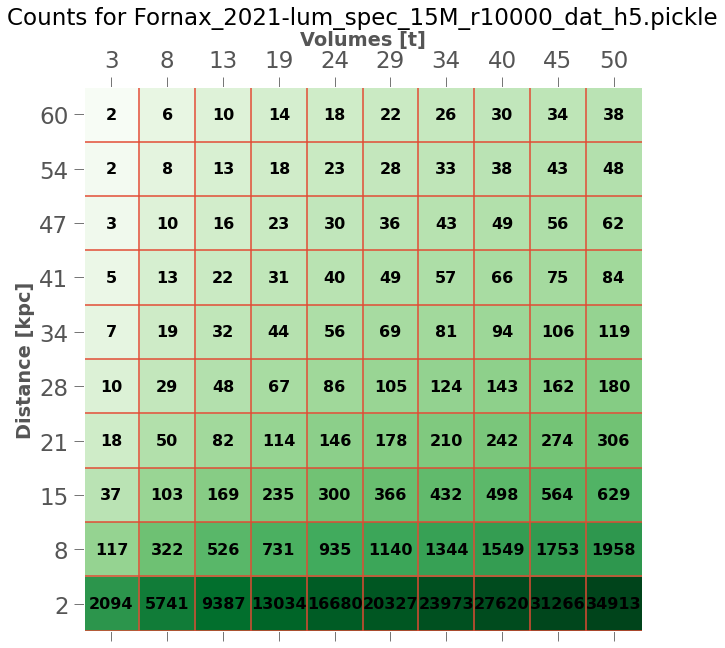

In [15]:
plotter.plot_counts()

## Simulate Signal with WFSim

These parts are better done in dali/midway. <br>


In [8]:
import nestpy
import pandas as pd
import straxen
downloader = straxen.MongoDownloader()

In [9]:
field_file="fieldmap_2D_B2d75n_C2d75n_G0d3p_A4d9p_T0d9n_PMTs1d3n_FSR0d65p_QPTFE_0d5n_0d4p.json.gz"
field_map = straxen.InterpolatingMap(
                    straxen.get_resource(downloader.download_single(field_file),
                                         fmt="json.gz"),
                    method="RegularGridInterpolator")

nc = nestpy.NESTcalc(nestpy.DetectorExample_XENON10())
## not sure if nestpy RNG issue was solved, so randomize NEST internal state
for i in range(np.random.randint(100)):
    nc.GetQuanta(nc.GetYields(energy=np.random.uniform(10,100)))

*** Detector definition message ***
You are currently using the default XENON10 template detector.



Caution, the times need to be passed in nanoseconds!

In [10]:
N_events = 3000
sampled_Er = A.sample_data(N_events)
sampled_t = A.sample_data(N_events, dtype='time')

### How to handle times 

Now we are going to create instructions for the SuperNova signal. However, for a real supernova we expect to have ~100 events. Thus those "realistic simulations" will be very sparse (nonetheless, still needed). <br>
This would be
```python
instr = generator_sn_instruction(energy_deposition=sampled_Er, timemode=sampled_t*1e9, n_tot=N_events, nc=nc, fmap=field_map)
```


We also want to study the general shape, for that, we simulate a signal with higher statistics. <br>
If we simulate thousands of events within 10 sec, buffer will crash. We need to simulate smarter, for this we will simulate total number of expected interactions within expected duration (e.g. 100 within 10 sec), then move the times and simulate again. <br>

For completeness the `generator_sn_instruction()` also has two more time modes "realistic" and "uniform" which are still useful to study time-independent aspects such as S2 shape. However, in order to build a trigger that is based on the rate, we need to contain time information.

In [11]:
_instr = A.generate_instructions(energy_deposition=sampled_Er, 
                                 timemode=sampled_t*1e9, 
                                 n_tot=N_events, nc=nc, fmap=field_map)
df_realistic = pd.DataFrame(_instr)
print(f"Total duration {np.ptp(df_realistic['time'])*1e-9:.2f} seconds")
df_realistic

Total duration 3.80 seconds


,event_number,type,time,x,y,z,amp,recoil,e_dep,g4id,vol_id,local_field,n_excitons,x_pri,y_pri,z_pri
0,1,1,291688080,-37.316555,-11.286768,-19.568075,27,7,1.495361,0,0,25.877526,0,0.0,0.0,0.0
1,1,2,291688080,-37.316555,-11.286768,-19.568075,81,7,1.495361,0,0,25.877526,0,0.0,0.0,0.0
2,2,1,1391340239,45.897930,2.558551,-120.158379,10,7,0.783595,0,0,22.131447,0,0.0,0.0,0.0
3,2,2,1391340239,45.897930,2.558551,-120.158379,49,7,0.783595,0,0,22.131447,0,0.0,0.0,0.0
4,3,1,2285835719,-34.285831,36.264038,-129.417953,156,7,3.209040,0,0,22.416526,16,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5550,2998,2,185128270,34.947956,-44.680611,-53.549145,13,7,0.216672,0,0,21.953538,0,0.0,0.0,0.0
5551,2999,1,3775203750,-9.512318,-8.199062,-147.445679,460,7,7.417817,0,0,22.562533,38,0.0,0.0,0.0
5552,2999,2,3775203750,-9.512318,-8.199062,-147.445679,90,7,7.417817,0,0,22.562533,38,0.0,0.0,0.0
5553,3000,1,1080283056,-24.238224,29.834423,-125.078941,137,7,2.972868,0,0,22.357473,5,0.0,0.0,0.0


#### Simulate one high-statistics run, and get back the context.

In [12]:
instr = A.generate_instructions(energy_deposition=sampled_Er, 
                                timemode="shifted", 
                                n_tot=N_events, nc=nc, fmap=field_map)
df = pd.DataFrame(instr)
print(f"Total duration {np.ptp(df['time'])*1e-9:.2f} seconds")
df

Total duration 61.16 seconds


,event_number,type,time,x,y,z,amp,recoil,e_dep,g4id,vol_id,local_field,n_excitons,x_pri,y_pri,z_pri
0,1,1,289156663,-9.953676,28.739445,-3.145970,60,7,2.0,0,0,26.977329,2,0.0,0.0,0.0
1,1,2,289156663,-9.953676,28.739445,-3.145970,79,7,2.0,0,0,26.977329,2,0.0,0.0,0.0
2,2,1,485376797,27.890038,46.533512,-56.620289,323,7,6.0,0,0,21.993640,17,0.0,0.0,0.0
3,2,2,485376797,27.890038,46.533512,-56.620289,119,7,6.0,0,0,21.993640,17,0.0,0.0,0.0
4,6,1,2115366801,-28.847126,-45.129051,-75.288528,466,7,8.0,0,0,21.756938,39,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3855,2922,2,57684246383,5.826285,-37.904652,-85.750481,86,7,2.0,0,0,21.978094,3,0.0,0.0,0.0
3856,2923,1,57891424478,4.460214,26.202465,-24.625042,518,7,8.0,0,0,25.120438,46,0.0,0.0,0.0
3857,2923,2,57891424478,4.460214,26.202465,-24.625042,70,7,8.0,0,0,25.120438,46,0.0,0.0,0.0
3858,2925,1,57898718752,20.855003,-55.026558,-142.038727,15,7,1.0,0,0,23.935214,1,0.0,0.0,0.0


~60 sec makes sense, since we simulate 3000 events in a 7 ton volume at 10kpc, and single SN has ~195 events at this range. Thus, 3000//195 = 60 iterations, and the single SN duration is ~4s (for this model) thus shifting times after each single simulation gives ~60 seconds.

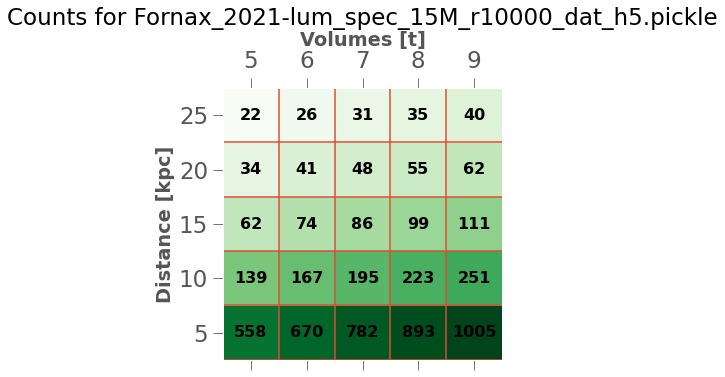

In [13]:
plotter.plot_counts(volumes=np.linspace(5,9,5), distances=np.linspace(5,25,5), figsize=(5,5))

### Simulate

We use WFSim to simulate supernova signal. The multimessenger package has some tools to create instructions and then simulate signal. <br>
First thing we want to check with the simulations is the effect of the s1 threshold. <br>
By default multimmessenger package uses a default simulation context, but any other context can be passed. Thus, we modify a context and use that for simulation.

In [16]:
runid = "sim_supernova"
# st = A.simulate_one(df, runid)

Or one can create a context with the desired configuration and pass that context for simulation.

In [17]:
import cutax, strax
st = cutax.contexts.xenonnt_sim_SR0v2_cmt_v8(cmt_run_id="026000", output_folder=os.path.join(A.config['wfsim']['sim_folder'], "strax_data"))

In [18]:
# pd.options.display.max_rows = 70
# st.show_config("peak_basics").iloc[-6:]

In [19]:
# set s1 minimum coincidence to 0
st.set_config({"s1_min_coincidence":0})
st.show_config("peak_basics").iloc[-6:-5]

,option,default,current,applies_to,help
57,s1_min_coincidence,2,0,"(peaklet_classification,)",Minimum tight coincidence necessary to make an S1


In [ ]:
# simulate with this context
st = A.simulate_one(df, runid, context=st)

> Checking to see if you have strax already!


/home/melih/software/WFSim/wfsim/load_resource.py:262: RuntimeWarning: invalid value encountered in true_divide
  orig_aft_=np.mean((s2map_topeff_/s2map_toteff_)[s2map_toteff_>0.0])
*** Detector definition message ***
You are currently using the default XENON10 template detector.



Simulating Raw Records:   0%|          | 0/3748 [00:00<?, ?it/s]

In [20]:
peak_basics = st.get_df(runid, "peak_basics")
peak_s1 = peak_basics[peak_basics['type'] == 1]
peak_s2 = peak_basics[peak_basics['type'] == 2]
peak_basics['type'].unique(), sum(peak_basics['type']==0), sum(peak_basics['type']==1), sum(peak_basics['type']==2)

Loading peak_basics: |          | 0.00 % [00:00<?]

(array([1, 2, 0], dtype=int8), 24, 1789, 1982)

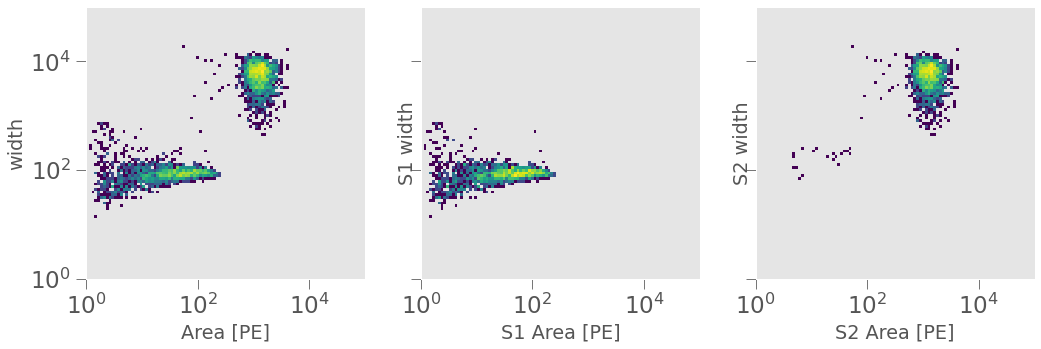

In [23]:
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(17,5), sharex=True, sharey=True)
ax0.grid(False)
ax1.grid(False)
ax2.grid(False)
ax0.hist2d(peak_basics["area"], peak_basics["range_50p_area"], 
           bins=(np.logspace(0,5,100),np.logspace(0,5,100)),
           norm=LogNorm());
ax0.set_xscale("log"); ax0.set_yscale("log")
ax0.set_xlabel("Area [PE]"); ax0.set_ylabel("width");


ax1.hist2d(peak_s1["area"], peak_s1["range_50p_area"], 
           bins=(np.logspace(0,5,100),np.logspace(0,5,100)),
           norm=LogNorm());
ax1.set_xscale("log"); ax1.set_yscale("log")
ax1.set_xlabel("S1 Area [PE]"); ax1.set_ylabel("S1 width");

ax2.hist2d(peak_s2["area"], peak_s2["range_50p_area"], 
           bins=(np.logspace(0,5,100),np.logspace(0,5,100)),
           norm=LogNorm());
ax2.set_xscale("log"); ax2.set_yscale("log")
ax2.set_xlabel("S2 Area [PE]"); ax2.set_ylabel("S2 width");

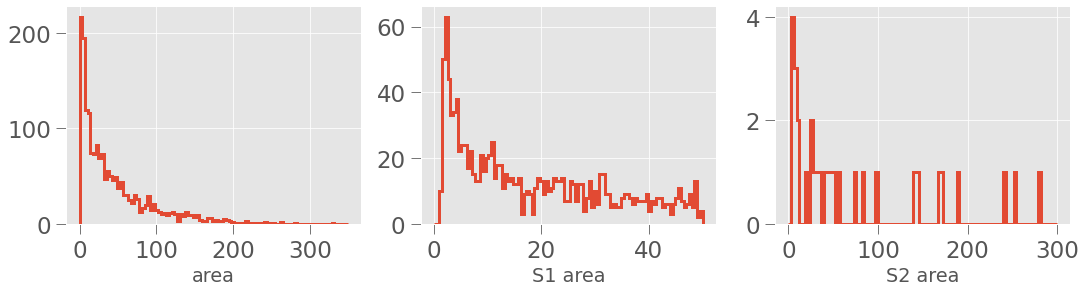

In [24]:
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(18,4))
ax0.hist(peak_basics['area'], bins=np.linspace(0, 350, 100), histtype='step', lw=3)
ax1.hist(peak_s1['area'], bins=np.linspace(0, 50, 100), histtype='step', lw=3)
ax2.hist(peak_s2['area'], bins=np.linspace(0,300,100), histtype='step', lw=3);
ax0.set_xlabel("area"); ax1.set_xlabel("S1 area"); ax2.set_xlabel("S2 area");

### Get a simulation with default context
We can try to make peaks using the unchanged context which uses min s1 coincidence threshold as 2 fold.

In [25]:
st_unchanged = A.simulate_one(df, runid)
st_unchanged.show_config("peak_basics").iloc[-6:-5]

/dali/lgrandi/xenonnt/software/cutax/latest/cutax/contexts.py:85: UserWarning: WARNING! You are using SR0 v1 simulation context! Consider updating to a newer version!
  warnings.warn("WARNING! You are using SR0 v1 simulation context! Consider updating to a newer version!")
/home/melih/software/WFSim/wfsim/load_resource.py:262: RuntimeWarning: invalid value encountered in true_divide
  orig_aft_=np.mean((s2map_topeff_/s2map_toteff_)[s2map_toteff_>0.0])
*** Detector definition message ***
You are currently using the default XENON10 template detector.



Simulating Raw Records:   0%|          | 0/3868 [00:00<?, ?it/s]

Source finished!


snsim_shifted_times is created! Returning context!


,option,default,current,applies_to,help
57,s1_min_coincidence,2,<OMITTED>,"(peaklet_classification,)",Minimum tight coincidence necessary to make an S1


In [35]:
_peak_basics = st_unchanged.get_df(runid, "peak_basics")
_peak_s1 = _peak_basics[_peak_basics['type'] == 1]
_peak_s2 = _peak_basics[_peak_basics['type'] == 2]
_peak_basics['type'].unique(), sum(_peak_basics['type']==0), sum(_peak_basics['type']==1), sum(_peak_basics['type']==2)

Loading peak_basics: |          | 0.00 % [00:00<?]

(array([2, 1, 0], dtype=int8), 36, 660, 978)

/tmp/jobs/21865128/ipykernel_319/2527553398.py:2: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax0.hist2d(_peak_basics["area"], _peak_basics["range_50p_area"],
/tmp/jobs/21865128/ipykernel_319/2527553398.py:9: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax1.hist2d(_peak_s1["area"], _peak_s1["range_50p_area"],
/tmp/jobs/21865128/ipykernel_319/2527553398.py:15: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax2.hist2d(_peak_s2["area"], _peak_s2["range_50p_area"],


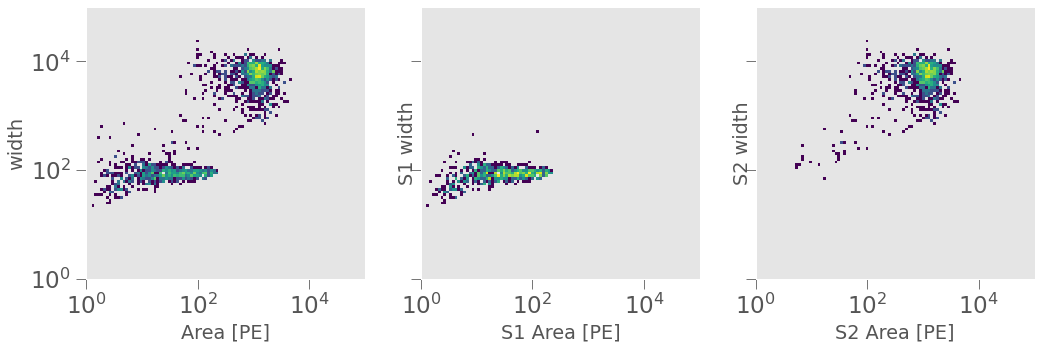

In [36]:
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(17,5), sharex=True, sharey=True)
ax0.hist2d(_peak_basics["area"], _peak_basics["range_50p_area"], 
           bins=(np.logspace(0,5,100),np.logspace(0,5,100)),
           norm=LogNorm());
ax0.set_xscale("log"); ax0.set_yscale("log")
ax0.set_xlabel("Area [PE]"); ax0.set_ylabel("width");


ax1.hist2d(_peak_s1["area"], _peak_s1["range_50p_area"], 
           bins=(np.logspace(0,5,100),np.logspace(0,5,100)),
           norm=LogNorm());
ax1.set_xscale("log"); ax1.set_yscale("log")
ax1.set_xlabel("S1 Area [PE]"); ax1.set_ylabel("S1 width");

ax2.hist2d(_peak_s2["area"], _peak_s2["range_50p_area"], 
           bins=(np.logspace(0,5,100),np.logspace(0,5,100)),
           norm=LogNorm());
ax2.set_xscale("log"); ax2.set_yscale("log")
ax2.set_xlabel("S2 Area [PE]"); ax2.set_ylabel("S2 width");

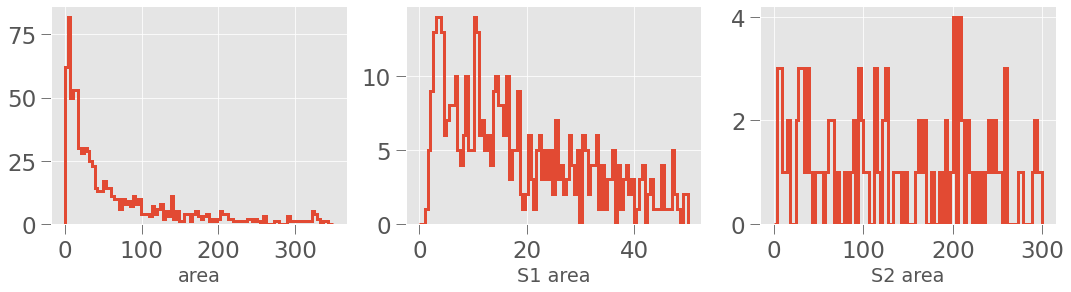

In [37]:
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(18,4))
ax0.hist(_peak_basics['area'], bins=np.linspace(0, 350, 100), histtype='step', lw=3)
ax1.hist(_peak_s1['area'], bins=np.linspace(0, 50, 100), histtype='step', lw=3)
ax2.hist(_peak_s2['area'], bins=np.linspace(0,300,100), histtype='step', lw=3);
ax0.set_xlabel("area"); ax1.set_xlabel("S1 area"); ax2.set_xlabel("S2 area");

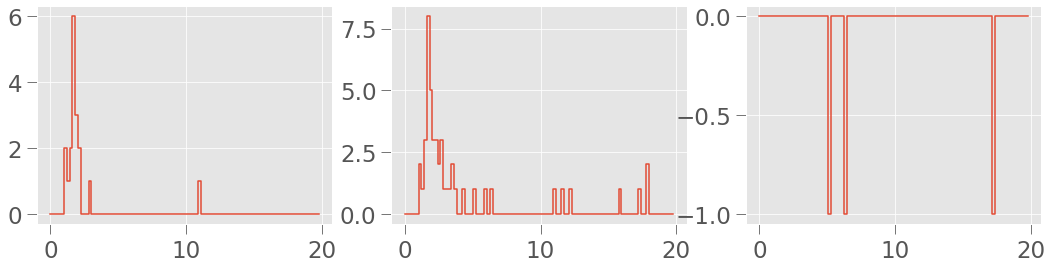

In [38]:
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(18,4))
a, b = np.histogram(peak_basics['area'], bins=np.linspace(0,20,100))
_a = np.histogram(_peak_basics['area'], bins=np.linspace(0,20,100))[0]
ax0.step(b[:-1], a-_a);

a, b = np.histogram(peak_s1['area'], bins=np.linspace(0,20,100))
_a = np.histogram(_peak_s1['area'], bins=np.linspace(0,20,100))[0]
ax1.step(b[:-1], a-_a);

a, b = np.histogram(peak_s2['area'], bins=np.linspace(0,20,100))
_a = np.histogram(_peak_s2['area'], bins=np.linspace(0,20,100))[0]
ax2.step(b[:-1], a-_a);

Extra: The utilix package allows for easy job submission, however, I haven't implemented that yet.

In [ ]:
# from utilix.batchq import submit_job
# submit_job()